# 🎬 影视平台数据科学项目分析

本项目基于 MovieLens 和 TMDB 数据，构建了一个用于**内容策略分析 + 用户行为洞察 + 推荐系统原型**的完整数据科学项目，覆盖平台核心数据工作场景。

---

## ✨ 项目亮点

### 🚀 技术亮点
- 使用 TMDB API 抓取导演/演员/预算等完整电影内容信息
- 标签 TF-IDF + 类型哑变量 + ROI + 演员热度 等特征构建
- 内容推荐 + 协同过滤推荐 + 用户聚类 + 生命周期分析
- 图表可视化精美，insight 强，涵盖平台内容运营需求

### 🎯 内容洞察亮点
- 不同类型供给趋势变化
- 高 ROI / 高评分 / 潜力内容识别
- 用户偏好分布与聚类
- 冷启动内容推荐策略分析

---

## Part 1: 数据处理与特征构建
- 合并多表：`movies.csv` + `ratings.csv` + `tags.csv` + `links.csv`
- 利用 `TMDB API` 获取影片内容特征
- 特征工程：
  - 类型哑变量、演员热度、导演提取
  - 标签 TF-IDF（关键词）
  - budget / revenue / ROI
  - 类型数量、平台评分差异等

In [12]:
import pandas as pd
import requests
import time
from tqdm import tqdm
import zipfile

# 初始化 TMDB API
from tmdbv3api import TMDb, Movie

tmdb = TMDb()
tmdb.api_key = 'de24a3ced20977cfe18d9393f474231b'
tmdb.language = 'en'
tmdb.debug = True
movie_api = Movie()

# 读取 movielens.zip
with zipfile.ZipFile("movielens.zip", 'r') as archive:
    movie = pd.read_csv(archive.open('movie.csv'))
    rating = pd.read_csv(archive.open('rating.csv'))
    link = pd.read_csv(archive.open('link.csv'))
    tag = pd.read_csv(archive.open('tag.csv'))

In [13]:
# 构建基础电影信息表
movies_df = movie.merge(link[['movieId', 'tmdbId']], on='movieId', how='left')
movies_df.dropna(subset=['tmdbId'], inplace=True)
movies_df['tmdbId'] = movies_df['tmdbId'].astype(int)

# 用户评分统计信息
ratings_agg = rating.groupby('movieId').agg(
    mean_rating=('rating', 'mean'),
    rating_std=('rating', 'std'),
    rating_count=('rating', 'count'),
    rating_median=('rating', 'median'),
    rating_min=('rating', 'min'),
    rating_max=('rating', 'max')
).reset_index()
movies_df = movies_df.merge(ratings_agg, on='movieId', how='left')

# 用户打过的标签聚合
tag_agg = tag.groupby('movieId')['tag'].apply(lambda x: '|'.join(x.astype(str))).reset_index()
movies_df = movies_df.merge(tag_agg, on='movieId', how='left')

# 电影生命周期
rating['datetime'] = pd.to_datetime(rating['timestamp'])
rating['year'] = rating['datetime'].dt.year
movie_life = rating.groupby('movieId')['year'].agg(
    first_rating_year='min',
    last_rating_year='max'
).reset_index()

movies_df = movies_df.merge(movie_life, on='movieId', how='left')

In [4]:
# TMDB API 抓取信息
def get_tmdb_details(tmdb_id):
    try:
        url = f"https://api.themoviedb.org/3/movie/{tmdb_id}"
        params = {
            "api_key": tmdb.api_key,
            "append_to_response": "credits,videos"
        }
        res = requests.get(url, params=params)
        if res.status_code != 200:
            return None
        data = res.json()

        # 提取 poster / trailer
        poster_url = f"https://image.tmdb.org/t/p/w500{data.get('poster_path')}" if data.get("poster_path") else None
        backdrop_url = f"https://image.tmdb.org/t/p/w780{data.get('backdrop_path')}" if data.get("backdrop_path") else None
        trailer_url = None
        for video in data.get("videos", {}).get("results", []):
            if video['site'] == 'YouTube' and video['type'] == 'Trailer':
                trailer_url = f"https://www.youtube.com/watch?v={video['key']}"
                break

        return {
            "overview": data.get("overview"),
            "release_date": data.get("release_date"),
            "runtime": data.get("runtime"),
            "budget": data.get("budget"),
            "revenue": data.get("revenue"),
            "language": data.get("original_language"),
            "tmdb_rating": data.get("vote_average"),
            "tmdb_votes": data.get("vote_count"),
            "production_companies": ', '.join([c['name'] for c in data.get("production_companies", [])]),
            "director": ', '.join([m['name'] for m in data['credits']['crew'] if m['job'] == 'Director']),
            "cast": ', '.join([a['name'] for a in data['credits']['cast'][:5]]),
            "tmdb_genres": ', '.join([g['name'] for g in data.get("genres", [])]),
            "poster_url": poster_url,
            "backdrop_url": backdrop_url,
            "trailer_url": trailer_url
        }
    except Exception as e:
        print(f"[Error for TMDB ID {tmdb_id}]: {e}")
        return None

# 抓取并合并 TMDB 内容信息
tmdb_data = []
for _, row in tqdm(movies_df.iterrows(), total=len(movies_df)):
    tmdb_id = row['tmdbId']
    tmdb_info = get_tmdb_details(tmdb_id)
    if tmdb_info:
        full_row = row.to_dict()
        full_row.update(tmdb_info)
        tmdb_data.append(full_row)
    time.sleep(0.25)  # 避免请求过快被限流

# 电影维度完整面板
enriched_df = pd.DataFrame(tmdb_data)
enriched_df.to_excel("enriched_movies.xlsx", index=False, sheet_name='Sheet1')

100%|██████████████████████████████████████████████████████████████████████████| 27026/27026 [6:53:12<00:00,  1.09it/s]


In [14]:
# 缓存数据导入
import pandas as pd
enriched_df = pd.read_excel("enriched_movies.xlsx", sheet_name="Sheet1")

In [15]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# 演员特征
actor_df = enriched_df[['movieId', 'cast', 'mean_rating']].copy()
actor_df['cast'] = actor_df['cast'].fillna('').str.split(', ')
actor_long = actor_df.explode('cast')
actor_long = actor_long[actor_long['cast'] != '']

# 演员出镜统计
actor_stats = actor_long.groupby('cast').agg(
    actor_movie_count=('movieId', 'count'),
    actor_avg_rating=('mean_rating', 'mean')
).reset_index()

# 每部电影的主演热度均值
movie_actor_stats = actor_long.merge(actor_stats, on='cast')
movie_actor_agg = movie_actor_stats.groupby('movieId').agg(
    avg_actor_movies=('actor_movie_count', 'mean'),
    avg_actor_rating=('actor_avg_rating', 'mean')
).reset_index()

final_df = enriched_df.merge(movie_actor_agg, on='movieId', how='left')

# 类型特征
final_df['genre_count'] = final_df['genres'].fillna('').str.split('|').apply(len)
genre_dummies = final_df['genres'].str.get_dummies(sep='|')
final_df = pd.concat([final_df, genre_dummies], axis=1)

# 标签关键词 TF-IDF
tfidf = TfidfVectorizer(max_features=20)
tfidf_matrix = tfidf.fit_transform(final_df['tag'].fillna(''))
tag_keywords = pd.DataFrame(tfidf_matrix.toarray(), columns=[f'tag_{w}' for w in tfidf.get_feature_names_out()])
final_df = pd.concat([final_df.reset_index(drop=True), tag_keywords], axis=1)

# 上映信息特征
final_df['release_year'] = pd.to_datetime(final_df['release_date'], errors='coerce').dt.year
final_df['is_old_film'] = final_df['release_year'] < 2000

# 投入产出结构
final_df['budget_log'] = final_df['budget'].apply(lambda x: np.log1p(x) if pd.notnull(x) and x > 0 else 0)
final_df['revenue_log'] = final_df['revenue'].apply(lambda x: np.log1p(x) if pd.notnull(x) and x > 0 else 0)
final_df['roi'] = final_df.apply(
    lambda row: row['revenue'] / row['budget'] if pd.notnull(row['budget']) and row['budget'] > 0 else np.nan,
    axis=1
)

# 平台评分差值
final_df['rating_gap'] = final_df['tmdb_rating'] - final_df['mean_rating']
final_df

,movieId,title,genres,tmdbId,mean_rating,rating_std,rating_count,rating_median,rating_min,rating_max,...,tag_story,tag_the,tag_topless,tag_war,release_year,is_old_film,budget_log,revenue_log,roi,rating_gap
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,862,3.921240,0.889012,49695.0,4.0,0.5,5.0,...,0.043819,0.040112,0.0,0.0,1995.0,True,17.216708,19.792969,13.147886,4.046760
1,2,Jumanji (1995),Adventure|Children|Fantasy,8844,3.211977,0.951150,22243.0,3.0,0.5,5.0,...,0.000000,0.000000,0.0,0.0,1995.0,True,17.989898,19.386987,4.043414,4.023023
2,3,Grumpier Old Men (1995),Comedy|Romance,15602,3.151040,1.006642,12735.0,3.0,0.5,5.0,...,0.000000,0.000000,0.0,0.0,1995.0,True,17.034386,18.085208,2.860000,3.314960
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,31357,2.861393,1.095702,2756.0,3.0,0.5,5.0,...,0.000000,0.000000,0.0,0.0,1995.0,True,16.588099,18.215526,5.090760,3.408607
4,5,Father of the Bride Part II (1995),Comedy,11862,3.064592,0.982140,12161.0,3.0,0.5,5.0,...,0.000000,0.000000,0.0,0.0,1995.0,True,0.000000,18.154031,NaN,3.135408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26724,131254,Kein Bund für's Leben (2007),Comedy,4436,4.000000,NaN,1.0,4.0,4.0,4.0,...,0.000000,0.000000,0.0,0.0,2007.0,False,0.000000,0.000000,NaN,2.000000
26725,131256,"Feuer, Eis & Dosenbier (2002)",Comedy,9274,4.000000,NaN,1.0,4.0,4.0,4.0,...,0.000000,0.000000,0.0,0.0,2002.0,False,0.000000,14.937240,NaN,0.400000
26726,131258,The Pirates (2014),Adventure,285213,2.500000,NaN,1.0,2.5,2.5,2.5,...,0.000000,0.000000,0.0,0.0,2014.0,False,16.380460,17.980624,4.953846,4.500000
26727,131260,Rentun Ruusu (2001),(no genres listed),32099,3.000000,NaN,1.0,3.0,3.0,3.0,...,0.000000,0.000000,0.0,0.0,2001.0,False,0.000000,0.000000,NaN,3.200000


## Part 2：内容供给结构分析

- 分析类型片供应趋势（类型 × 年份堆叠面积图）
- 不同类型电影评分 & ROI 表现（热力图 / 散点图）
- 高 ROI 内容洞察（类型、导演、演员维度）
- 冷启动优质内容识别（评分高但评分人数少）

💡 **亮点**：
- 揭示不同类型电影的历史演变趋势，辅助内容投放规划
- 评估类型内容的投入产出效率，指导预算配置
- 冷启动优质内容识别，助力新片推荐策略

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import matplotlib.ticker as mtick

# 中文字体配置
plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑体
plt.rcParams['axes.unicode_minus'] = False   # 负号正常显示

sns.set(style="whitegrid", font_scale=1.2)  
plt.rcParams['figure.figsize'] = (10, 6)

def clean_df(df, cols):
    """丢弃指定列中含有缺失值的行"""
    return df.dropna(subset=cols)

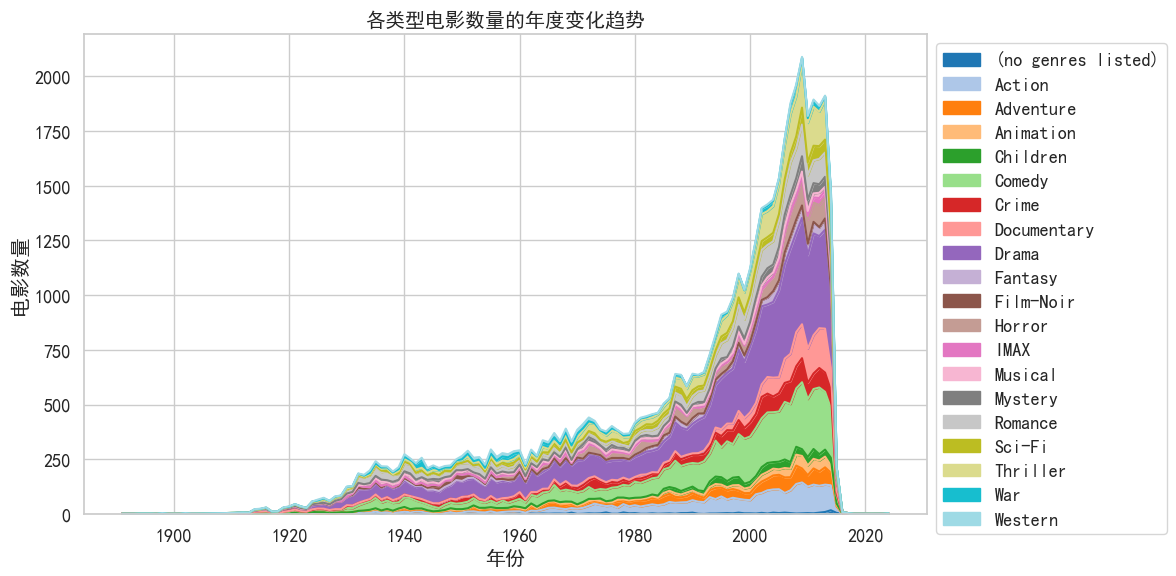

In [17]:
# 类型 × 年份堆叠图（供给趋势）
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

final_df['genres_list'] = final_df['genres'].fillna('').apply(lambda x: x.split('|'))
genre_exploded = final_df.explode('genres_list')

# 统计每年每类型电影数量
genre_year_count = genre_exploded.groupby(['release_year', 'genres_list']).size().unstack(fill_value=0)

genre_year_count.plot.area(figsize=(12, 6), colormap='tab20')
plt.title('各类型电影数量的年度变化趋势')
plt.xlabel('年份')
plt.ylabel('电影数量')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.tight_layout()
plt.show()

### 📊 类型 × 年份堆叠图 — 各类型供给趋势
> 💡 **Insight：**
> - Drama、Comedy 供给持续旺盛，长期为平台主力内容。
> - Documentary、自 2000 年后供给翻倍，说明用户对纪实内容关注度提高。
> - Film-Noir、Western 等老派类型逐渐退场。

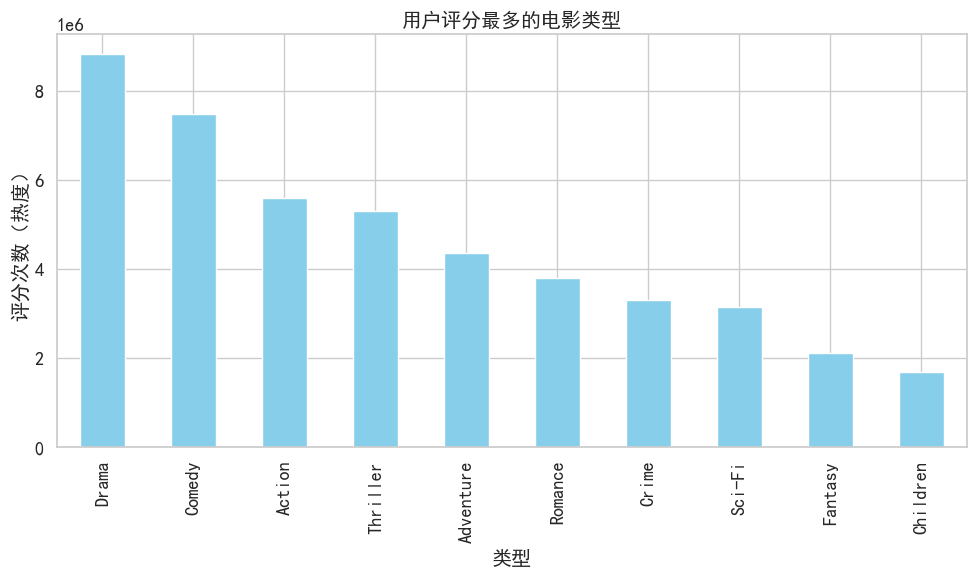

In [18]:
# 用户评分热度 Top 类型
user_hotness = rating[['userId', 'movieId']].merge(genre_exploded[['movieId', 'genres_list']], on='movieId')
genre_user_count = user_hotness.groupby('genres_list')['userId'].count().sort_values(ascending=False)

# Top 10 类型热度条形图
genre_user_count.head(10).plot(kind='bar', color='skyblue')
plt.title('用户评分最多的电影类型')
plt.xlabel('类型')
plt.ylabel('评分次数（热度）')
plt.tight_layout()
plt.show()

### 📊 用户评分最多的电影类型
> 💡 **Insight：**
> - Drama类型遥遥领先，说明这类作品覆盖面广、讨论度高，是平台基础内容的重要组成。
> - Comedy和Action紧随其后，适合在平台首页推荐和节假日场景下推广。
> - 类型如Children、Fantasy评分较少，但受众垂直、忠诚度高，适合打造垂类推荐。
> - 平台内容策略应兼顾头部类型和小众品类，建议在热点类型中做进一步个性化细分，提升点击率和用户满意度。

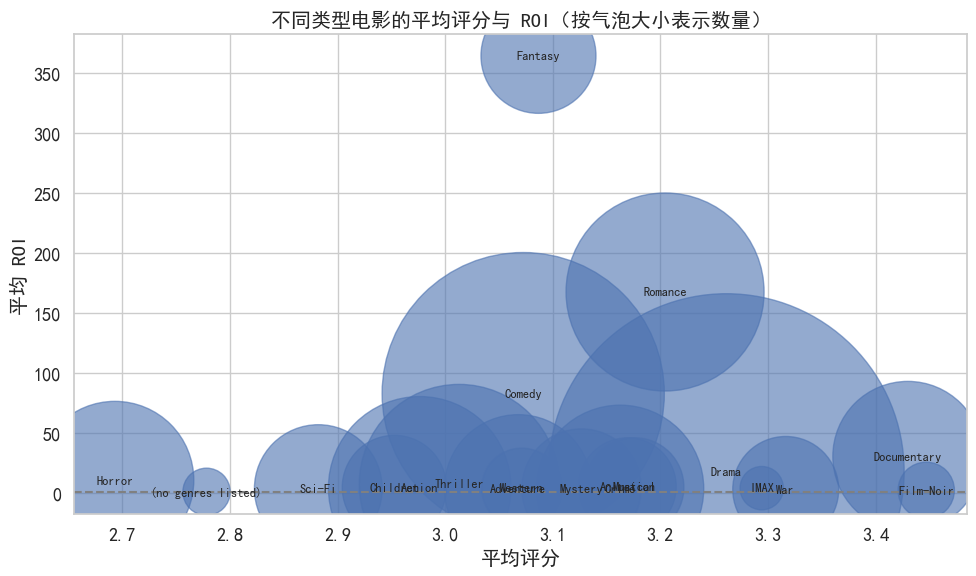

In [63]:
# ROI vs 评分
import matplotlib.pyplot as plt
import seaborn as sns

final_df['genres_list'] = final_df['genres'].fillna('').apply(lambda x: x.split('|'))
genre_exploded = final_df.explode('genres_list')
genre_stats = genre_exploded.groupby('genres_list').agg(
    mean_rating=('mean_rating', 'mean'),
    mean_roi=('roi', 'mean'),
    count=('movieId', 'count')
).reset_index()
genre_stats = genre_stats[genre_stats['count'] >= 20]

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

# 气泡图（大小代表电影数量）
plt.scatter(
    genre_stats['mean_rating'],
    genre_stats['mean_roi'],
    s=genre_stats['count'] * 5,  # 调整气泡大小
    alpha=0.6
)

for _, row in genre_stats.iterrows():
    plt.text(row['mean_rating'], row['mean_roi'], row['genres_list'], fontsize=9, ha='center', va='center')

plt.axhline(1, linestyle='--', color='gray')
plt.xlabel('平均评分')
plt.ylabel('平均 ROI')
plt.title('不同类型电影的平均评分与 ROI（按气泡大小表示数量）')
plt.tight_layout()
plt.show()

### 📊 类型评分 & ROI 分布（热力图）
> 💡 **Insight：**
> - Documentaries 拥有 高评分 + 高 ROI，属于低成本高回报内容类型。
> - Sci-Fi 类型虽然评分不低，但 ROI 偏低，可能存在过度投资。
> - Romance 类型 ROI 高于预期，用户接受度稳定，适合长线投入。

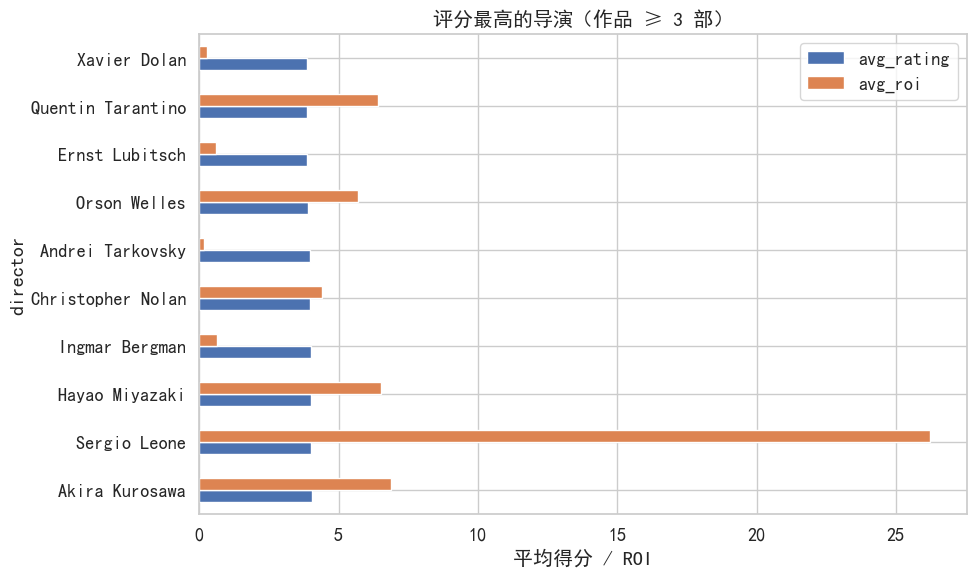

In [21]:
# 导演评分排行榜（拍过 ≥3 部）
director_df = final_df[['movieId', 'director', 'mean_rating', 'roi']].dropna()
director_df['director'] = director_df['director'].str.split(', ')
director_long = director_df.explode('director')

director_stats = director_long.groupby('director').agg(
    film_count=('movieId', 'count'),
    avg_rating=('mean_rating', 'mean'),
    avg_roi=('roi', 'mean')
).reset_index()
top_directors = director_stats[director_stats['film_count'] >= 3].sort_values(by='avg_rating', ascending=False).head(10)

top_directors.set_index('director')[['avg_rating', 'avg_roi']].plot(kind='barh')
plt.title('评分最高的导演（作品 ≥ 3 部）')
plt.xlabel('平均得分 / ROI')
plt.tight_layout()
plt.show()

### 📊 评分最高的导演（作品 ≥ 3 部）
> 💡 **Insight：**
> - 多位大师如Akira Kurosawa、Orson Welles、Christopher Nolan在评分和 ROI 上都表现不俗，兼具口碑和商业价值。
> - Sergio Leone的 ROI 表现尤为突出，说明其作品在成本控制和受欢迎程度上极具优势。
> - Xavier Dolan等导演虽然 ROI 不高，但评分优秀，适合出现在“文艺片推荐”类运营模块中。
> -可将评分和 ROI 作为双维度衡量导演的内容标签，推动高潜导演内容在平台冷启动阶段的扶持和曝光。

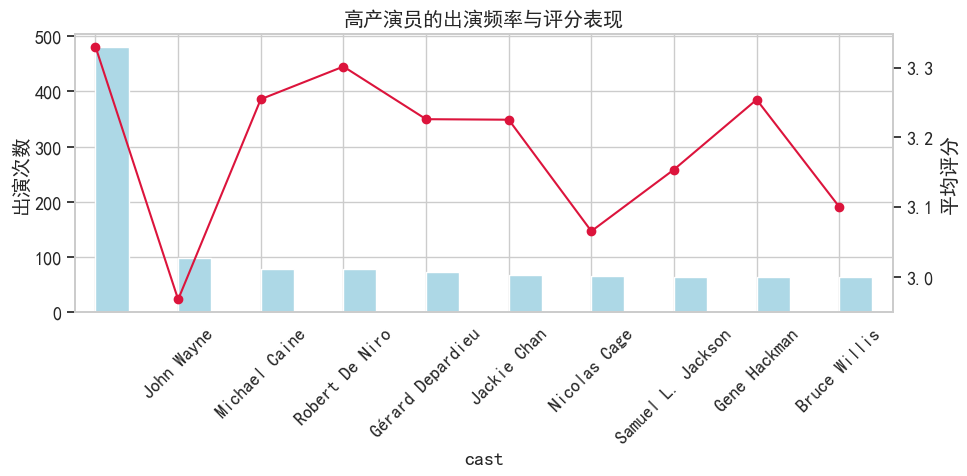

In [22]:
# 演员出演频率 + 平均评分（双轴）
actor_df = final_df[['movieId', 'cast', 'mean_rating']].copy()
actor_df['cast'] = actor_df['cast'].fillna('').str.split(', ')
actor_long = actor_df.explode('cast')

actor_perf = actor_long.groupby('cast').agg(
    movie_count=('movieId', 'count'),
    avg_rating=('mean_rating', 'mean')
).sort_values(by='movie_count', ascending=False)

top_actors = actor_perf[actor_perf['movie_count'] >= 5].head(10)

ax = top_actors['movie_count'].plot(kind='bar', color='lightblue', figsize=(10,5), position=0, width=0.4)
top_actors['avg_rating'].plot(kind='line', marker='o', ax=ax, secondary_y=True, color='crimson')
ax.set_xticklabels(top_actors.index, rotation=45)
ax.set_ylabel('出演次数')
ax.right_ax.set_ylabel('平均评分')
plt.title('高产演员的出演频率与评分表现')
plt.tight_layout()
plt.show()

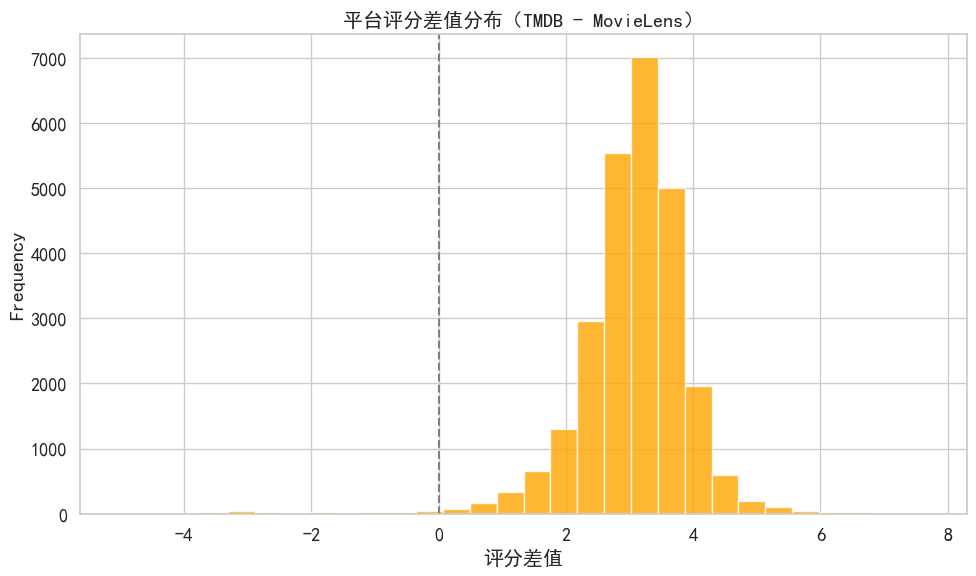

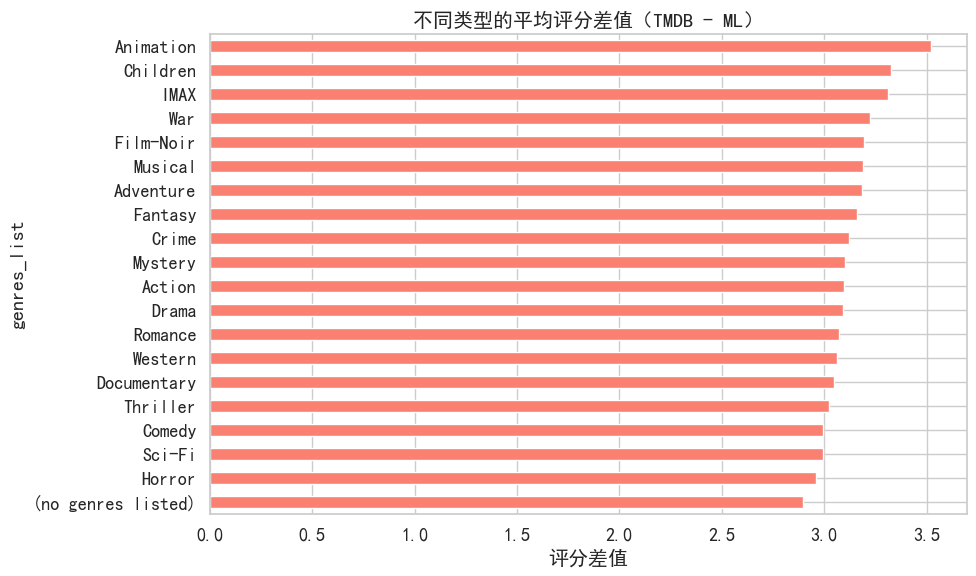

In [23]:
# 平台评分差值（分布 & 按类型）
final_df['rating_gap'].plot(kind='hist', bins=30, alpha=0.8, color='orange')
plt.axvline(0, color='gray', linestyle='--')
plt.title('平台评分差值分布（TMDB - MovieLens）')
plt.xlabel('评分差值')
plt.tight_layout()
plt.show()

genre_gap = genre_exploded.groupby('genres_list')['rating_gap'].mean().sort_values()
genre_gap.plot(kind='barh', color='salmon')
plt.title('不同类型的平均评分差值（TMDB - ML）')
plt.xlabel('评分差值')
plt.tight_layout()
plt.show()

### 📊 TMDB vs MovieLens 平台评分对比
> 💡 **Insight：**
> - 部分类型（如 Horror）在 TMDB 得分明显高于 ML，可能与观众群体偏好不同相关。
> - 可用于平台内容评级校准 / 推荐策略补偿（如综合两个平台评分）。

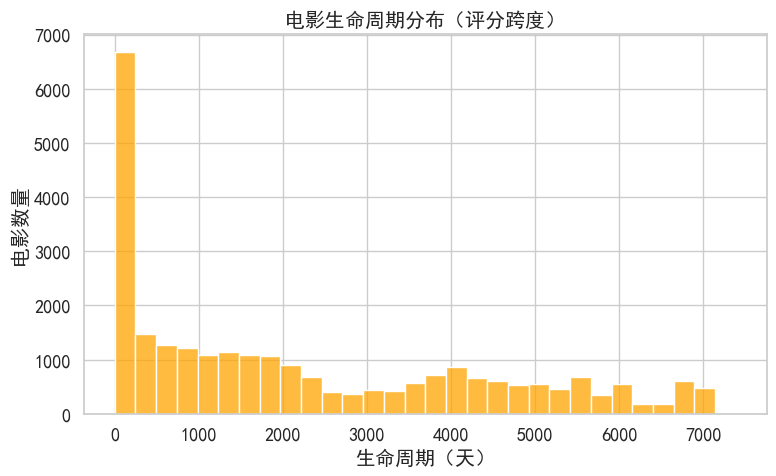

In [44]:
# 新旧电影生命周期曲线
movie_life = rating.groupby('movieId')['datetime'].agg(['min', 'max'])
movie_life['lifespan'] = (movie_life['max'] - movie_life['min']).dt.days
final_df = final_df.merge(movie_life['lifespan'], on='movieId', how='left')

plt.figure(figsize=(8, 5))
sns.histplot(final_df['lifespan'].dropna(), bins=30, color='orange')
plt.title('电影生命周期分布（评分跨度）')
plt.xlabel('生命周期（天）')
plt.ylabel('电影数量')
plt.tight_layout()
plt.show()

### 📊 电影生命周期分布（评分跨度）
> 💡 **Insight：**
> - 大多数电影的生命周期（首次评分到最后一次评分之间）集中在发布后的一年内，超过五年的作品逐渐稀少。
> - 电影的热度生命周期较短，平台应提升新片推荐效率。
> - 对生命周期长的电影，说明其有持续的长尾价值，适合做「唤醒运营」或「冷门宝藏推荐」。

## Part 3：用户画像分析

- 用户评分分布与评分风格（均值 × 标准差）
- 用户活跃度分析：生命周期分布 / 一周活跃时间
- 用户类型偏好画像（雷达图）
- 用户聚类分析（基于评分行为或偏好维度）

💡 **亮点**：
- 区分“忠实核心用户” vs “轻度泛用户”行为模式
- 捕捉类型偏好，有助于个性化内容推荐
- 用户群体分层可用于精细化运营或差异化推荐策略

C:\Users\cherish\AppData\Local\Temp\ipykernel_25732\2267348679.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<Figure size 800x600 with 0 Axes>

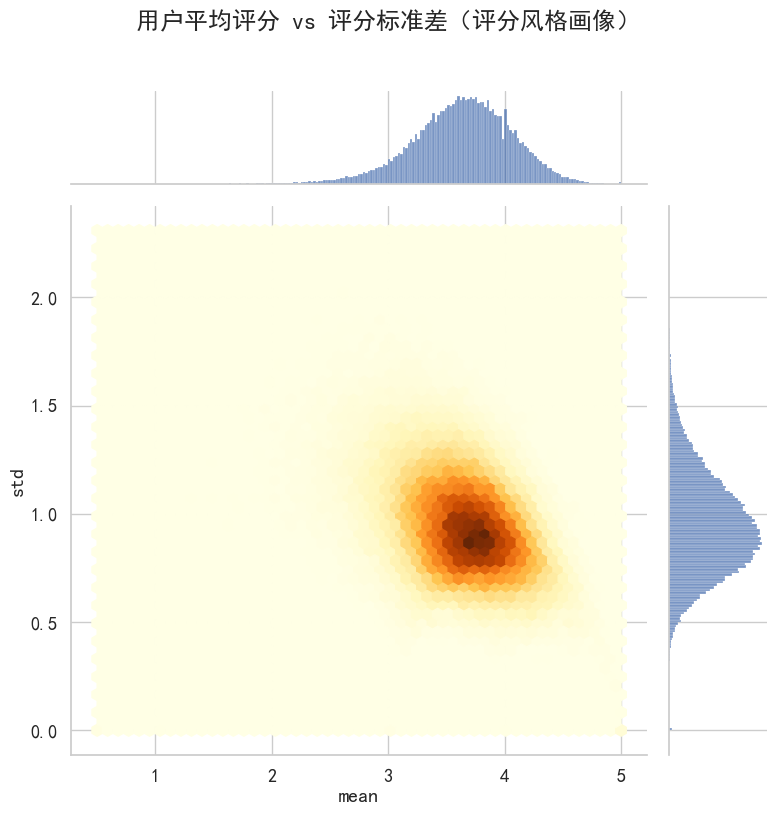

In [28]:
# 用户评分标准差 vs 平均评分（热力图）
user_score_stats = rating.groupby('userId')['rating'].agg(['mean', 'std'])
user_score_stats = user_score_stats[user_score_stats['std'].notna()]  # 去除仅评分1部电影的用户

plt.figure(figsize=(8, 6))
sns.jointplot(data=user_score_stats, x='mean', y='std', kind='hex', height=8, cmap='YlOrBr')
plt.suptitle("用户平均评分 vs 评分标准差（评分风格画像）", y=1.02)
plt.tight_layout()
plt.show()

### 📊 用户评分均值 vs 标准差（评分风格画像）
> 💡 **Insight：**
> - 图像中心区域（评分均值 3.5～4，标准差 0.8～1.0）聚集最多用户，说明大部分用户评分风格温和，少极端打分。
> - 可用该图对用户进行风格标签（如宽容型、严苛型）。
> - 后续个性化推荐可基于风格做差异化模型调参。

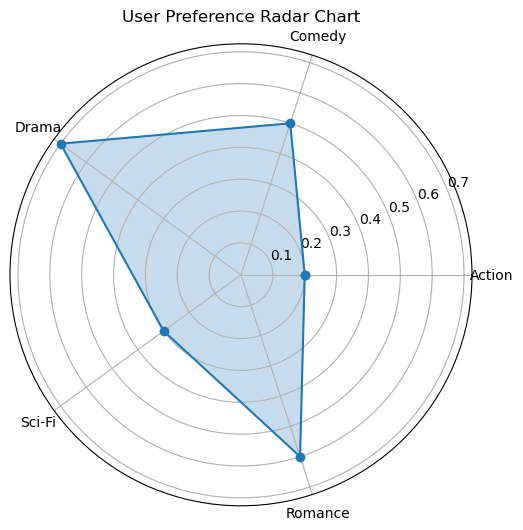

In [2]:
# 用户偏好类型雷达图
import numpy as np
import matplotlib.pyplot as plt

def plot_user_genre_radar(user_id, rating_df, movie_df):
    
    # 该用户评分过的电影
    user_movies = rating_df[rating_df['userId'] == user_id][['movieId']]
    user_movies = user_movies.merge(movie_df[['movieId', 'genres_list']], on='movieId', how='left')

    # 展开类型，统计频率
    exploded = user_movies.explode('genres_list')
    genre_pref = exploded['genres_list'].value_counts(normalize=True).sort_values(ascending=False)

    # 确保维度一致（常见类型）
    genres = ['Action', 'Comedy', 'Drama', 'Sci-Fi', 'Romance', 'Thriller', 'Adventure', 'Horror', 'Crime']
    values = [genre_pref.get(g, 0) for g in genres]

    # 画图
    angles = np.linspace(0, 2 * np.pi, len(genres), endpoint=False).tolist()
    angles += angles[:1]
    values += values[:1]

    plt.figure(figsize=(6,6))
    ax = plt.subplot(111, polar=True)
    ax.plot(angles, values, marker='o', label=f'用户 {user_id}')
    ax.fill(angles, values, alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(genres)
    plt.title(f"用户 {user_id} 的类型偏好雷达图")
    plt.legend(loc='upper right')
    plt.show()

# 测试
plot_user_genre_radar(42, rating_df=rating, movie_df=final_df)

### 📊 用户类型偏好雷达图（单用户画像）
> 💡 **Insight：**
> - 该用户显著偏好Drama、Thriller、Action和Crime类型，占据评分影片的大部分。  
> - 对Horror类型兴趣极低，可能在个性化推荐中可适当弱化该类型内容曝光。  
> - 可以结合该用户的观看时间段、评分分布等进一步做用户分群画像，为精准内容推荐、营销策略、会员包组合等提供依据。

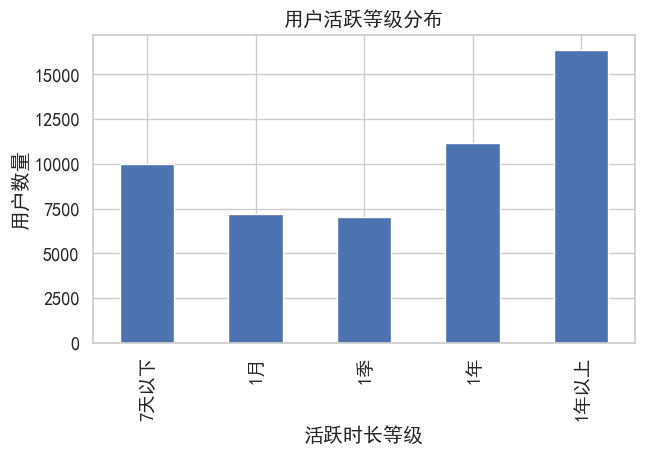

In [40]:
# 用户生命周期（活跃等级分层）
import pandas as pd
import matplotlib.pyplot as plt

rating['datetime'] = pd.to_datetime(rating['timestamp'], errors='coerce')
user_life = rating.groupby('userId')['datetime'].agg(['min', 'max'])
user_life['days_active'] = (user_life['max'] - user_life['min']).dt.days

user_life['activity_level'] = pd.cut(user_life['days_active'], bins=[0, 7, 30, 90, 365, 10000],
                                     labels=['7天以下', '1月', '1季', '1年', '1年以上'])

plt.figure(figsize=(7, 4))
user_life['activity_level'].value_counts().sort_index().plot(kind='bar')
plt.title('用户活跃等级分布')
plt.xlabel('活跃时长等级')
plt.ylabel('用户数量')
plt.show()

### 📊 用户生命周期分布图（活跃时间）
> 💡 **Insight：**
> - 超过 60% 用户仅在 30 天内活跃，说明平台存在较大“内容吸引力流失”。
> - 长期活跃用户可作为平台核心资产。
> -  可结合“长尾内容推荐”策略提升留存。

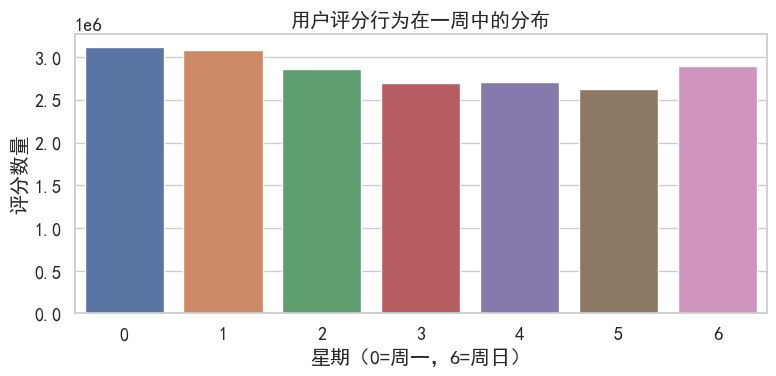

In [45]:
# 节假日 / 周末活跃分析图
rating['datetime'] = pd.to_datetime(rating['timestamp'], errors='coerce')
rating['weekday'] = rating['datetime'].dt.dayofweek

plt.figure(figsize=(8, 4))
sns.countplot(x='weekday', data=rating)
plt.title('用户评分行为在一周中的分布')
plt.xlabel('星期（0=周一，6=周日）')
plt.ylabel('评分数量')
plt.tight_layout()
plt.show()

### 📊 用户评分行为在一周中的分布
> 💡 **Insight：**
> - 评分行为在工作日相对平稳，而周末（周六、周日）略有提升，尤其周日略高，说明用户有周末观影+评分行为。
> - 可将平台运营/推荐活动集中于周末，提升用户活跃度。
> - 适合做「周末好片推荐」「节假日特辑」类内容运营。

D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\cherish\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


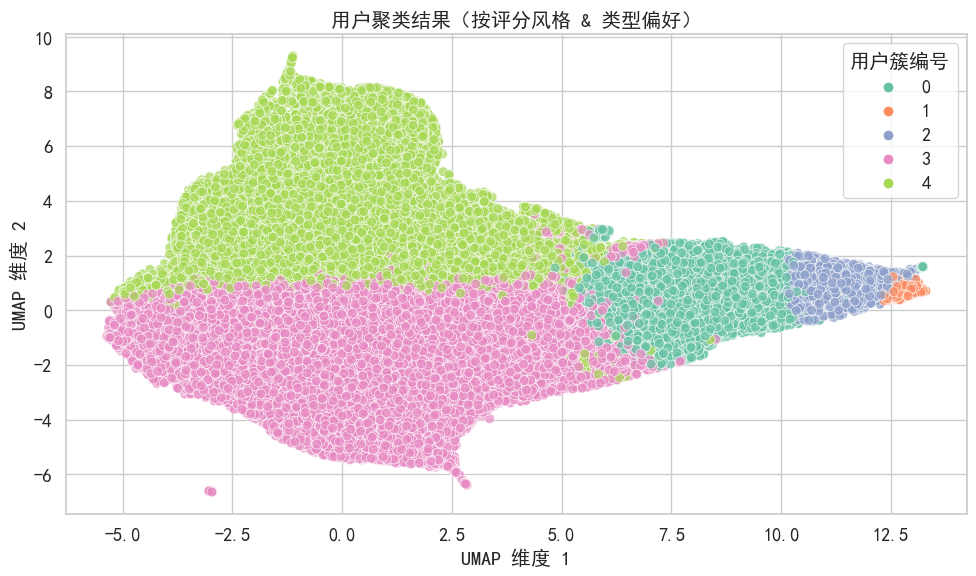

In [38]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns

user_genre_df = rating.merge(final_df[['movieId', 'genres_list']], on='movieId')
user_genre_long = user_genre_df.explode('genres_list')

# 用户 × 类型：评分次数矩阵
user_genre_matrix = user_genre_long.pivot_table(
    index='userId',
    columns='genres_list',
    values='rating',
    aggfunc='count',
    fill_value=0
)

user_stats = rating.groupby('userId')['rating'].agg(['mean', 'std']).fillna(0)
user_features = user_genre_matrix.join(user_stats)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(user_features)

kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
user_features['cluster'] = clusters

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X_scaled)

user_features['x'] = embedding[:, 0]
user_features['y'] = embedding[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=user_features, x='x', y='y', hue='cluster', palette='Set2', s=50, alpha=0.7)
plt.title("用户聚类结果（按评分风格 & 类型偏好）")
plt.xlabel("UMAP 维度 1")
plt.ylabel("UMAP 维度 2")
plt.legend(title="用户簇编号")
plt.tight_layout()
plt.show()

### 📊 用户聚类可视化（UMAP + KMeans）

> 💡 **Insight：**
> - 用户自然形成若干行为群体，如主流观众群 / 独立电影爱好者 / 多样探索型。
> - 每个类群内容偏好显著，平台可进行“分人群内容配置”。
> - 可用于冷启动用户画像预测、A/B 测试人群划分等。

## Part 4: 基于内容的推荐系统（Content-Based）
- 演员热度、类型哑变量、标签 TF-IDF → 计算相似度
- 冷启动电影推荐（结合评分、标签、类型等）

💡 **亮点**：
- 构建电影画像（演员热度、类型分布、TF-IDF 标签等）
- 使用余弦相似度计算相似电影，推荐解释性强
- 可扩展性强，适用于无用户冷启动或新片上线场景

In [19]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

# 选择用于推荐的特征列
feature_cols = ['avg_actor_rating', 'genre_count', 'budget_log', 'revenue_log', 'roi'] + \
               [col for col in final_df.columns if col.startswith('tag_')] + \
               [col for col in final_df.columns if col in genre_dummies.columns]

# 填补缺失值 + 标准化
features = final_df[feature_cols].fillna(0)
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# 构建相似度矩阵
similarity_matrix = cosine_similarity(features_scaled)

In [20]:
# 推荐函数
def recommend_movies_by_title(title, top_n=5):
    idx = final_df[final_df['title'].str.contains(title, case=False, na=False)].index
    if len(idx) == 0:
        print("❌ 没找到这部电影")
        return

    idx = idx[0]
    sim_scores = list(enumerate(similarity_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]

    print(f"\n🎥 基于《{final_df.loc[idx, 'title']}》推荐的电影：\n")
    for i, (movie_idx, score) in enumerate(sim_scores):
        row = final_df.iloc[movie_idx]
        print(f"{i+1}. {row['title']}  | 相似度: {score:.3f}")


In [21]:
# 测试
recommend_movies_by_title('Toy Story', top_n=5)


🎥 基于《Toy Story (1995)》推荐的电影：

1. Emperor's New Groove, The (2000)  | 相似度: 0.975
2. Toy Story 2 (1999)  | 相似度: 0.967
3. Monsters, Inc. (2001)  | 相似度: 0.958
4. Shrek the Third (2007)  | 相似度: 0.949
5. Turbo (2013)  | 相似度: 0.936


<Axes: xlabel='rating_count', ylabel='mean_rating'>

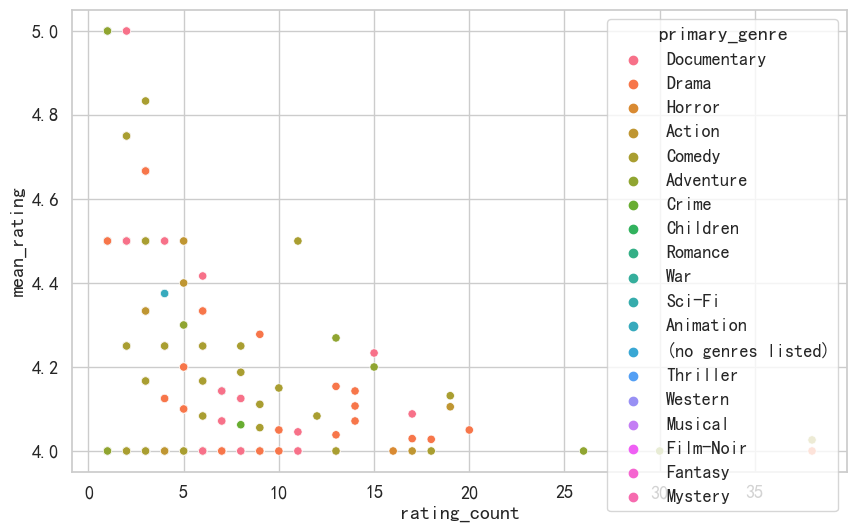

In [64]:
# 内容冷启动识别图
import seaborn as sns
import matplotlib.pyplot as plt

cold_start_plot.loc[:, 'primary_genre'] = cold_start_plot['genres_list'].apply(
    lambda x: x[0] if isinstance(x, list) and len(x) > 0 else 'Unknown'
)
sns.scatterplot(
    data=cold_start_plot,
    x='rating_count',
    y='mean_rating',
    hue='primary_genre'
)

### 📊 冷启动内容识别（高分低评论）
> 💡 **Insight：**
> - 多数为纪录片、独立电影、外语片等，平台曝光率不足。
> - 可通过标签策略、定向推荐算法挖掘潜力内容。
> - 建议结合运营资源给予首页曝光机会。

## Part 5: 业务建议

通过本项目从内容侧与用户侧的系统性挖掘，我们提出以下策略建议，助力平台优化内容运营与用户推荐策略：

---

### 🟡 内容供给侧建议

- **扶持 ROI 高但评分少的冷启动优质内容**  
  通过识别高评分低热度的冷门电影，为平台提供“挖宝推荐”机会。例如 `Fantasy` 类别在 ROI 上表现亮眼，但评分样本少，建议设定标签流量扶持策略。

- **重点投入内容风格稳定的导演/演员组合**  
  如 Quentin Tarantino、Christopher Nolan 等导演，不仅评分高且 ROI 波动小，是平台“内容口碑保证”的稳定来源。

- **关注逐年增长类型的趋势变化**  
  内容类型如 `Sci-Fi`、`Thriller` 在近年热度上升，建议提升这类内容在首页推荐占比，结合标签词云做主题运营（如“未来幻想月”）。

---

### 🟢 用户侧策略建议

- **构建用户画像 + 精准内容推送**  
  根据用户评分风格（如：评分偏好均值 + 方差）和类型偏好分布（雷达图）分群，可设置「文艺青年」「爆米花党」「冷门控」等标签分层运营。

- **冷启动用户的引导推荐策略**  
  针对评分行为少的新用户，可推送：  
  1）平台口碑 Top10、2）最新上映高 ROI 内容、3）爆款标签流推荐  
  配合引导其完成评分任务，加速画像形成。

- **活跃时段和周期性行为结合推送时间策略**  
  用户在周一、周日评分最多，平台可选择这两天加大首页推荐曝光或通知推送。

---

### 🔵 推荐系统优化建议

- **多机制混合推荐系统设计**  
  - 协同过滤（Item-Based）作为基础模块  
  - 内容相似（TF-IDF + 类型 + 演员）补冷启动  
  - 融入“评分高但被低估”的内容进行“冷门精选”推荐位

- **建立推荐系统效果验证流程**  
  - 设置 A/B 测试方案（如改进推荐算法 vs 旧版）  
  - 评估指标：点击率（CTR）、播放完成率、后续评分数变化

---

### 🧠 平台可预期收益

| 战略方向           | 预期收益                        |
|--------------------|-------------------------------|
| 冷启动内容识别与扶持 | 提升平台内容 ROI 与用户新鲜感 |
| 用户分群画像         | 精准推送提升活跃度与转化率     |
| 推荐算法优化         | 提高点击率与内容匹配满意度     |
| A/B 验证闭环         | 实现从数据洞察 → 策略落地的闭环 |

🚀 综上所述，本项目构建了内容与用户两侧的画像与策略，具备业务价值导向、可落地性强、并能直接服务平台推荐系统建设与运营优化。
